In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../features/')
from rule_based_churn import *

In [2]:
data_path = "../data/"

In [3]:
#load data

df = pd.read_csv(data_path+'sub_df.csv')
df.head()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id
0,2017-12-04,2017-12-19,728963,537935,78.53235,17,by phone,8281
1,2019-06-18,2019-06-18,153024,720868,236.65528,41,at the store,10891
2,2019-04-24,2019-04-24,63638,1099886,29.55960,9,at the store,4471
3,2018-02-21,2018-02-21,2452526,1904292,117.53460,9,online,5489
4,2019-01-16,2019-02-07,1094311,513380,651.85680,3,by phone,9220


## Rule Based Model

First, we group our dataset by client_id and by order_date. Then we add a new column called "order_number" that counts the number of order for each client. If an order has been done on the same day, for the same client_id, we consider that it is the same order and the order_number stays the same.

In addition, we drop the lines with clients having only placed 1 order because we do not consider them as regulars clients and do not want to tke them into consideration when predicting churn.

In [8]:
df_grouped = count_orders_per_client(df)
df_grouped.head()

Next, we compute the time difference between orders for a client. We calculate this column in terms of days and we it will later be used to calaculate the frequency of purchasig for a specific client, which will be the base of how we define churn.

In [49]:
time_dif = compute_time_difference_between_orders(df_grouped)
time_dif.head()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id,order_number,time_diff
1050002,2017-09-26,2017-09-27,2310611,14,160.135200,3,online,10319,1,NaN
1814466,2017-09-26,2017-09-26,2927672,14,105.763200,3,online,10319,1,0.0
1392104,2017-09-27,2017-10-18,107124,14,372.454333,13,by phone,10319,2,1.0
518047,2017-10-02,2017-10-09,738349,14,1.628400,3,by phone,10319,3,5.0
1303508,2017-10-03,2017-10-03,1095180,14,199.078800,3,by phone,10319,4,1.0


In [55]:
mean_time_diff = time_dif.groupby('client_id')['time_diff'].mean().reset_index(name='mean_time_diff')
mean_time_diff['mean_time_diff'] = round(mean_time_diff['mean_time_diff'], 2)
mean_time_diff['std_time_diff'] = time_dif.groupby('client_id')['time_diff'].std().reset_index(name='std_time_diff')['std_time_diff']
mean_time_diff['std_time_diff'] = round(mean_time_diff['std_time_diff'], 2)
mean_time_diff

,client_id,mean_time_diff,std_time_diff
0,14,1.81,2.33
1,18,9.68,8.89
2,37,1.00,NaN
3,40,106.40,141.64
4,56,39.10,34.39
...,...,...,...
84549,2274299,5.97,10.36
84550,2274322,63.00,55.73
84551,2274336,207.50,94.05
84552,2274410,40.00,36.63


In [56]:
# Join the mean time difference and the standard deviation back to the original data
df_churned = df.merge(mean_time_diff, on='client_id', how='left')
df_churned

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id,mean_time_diff,std_time_diff
0,2017-12-04,2017-12-19,728963,537935,78.532350,17,by phone,8281,2.22,2.84
1,2019-06-18,2019-06-18,153024,720868,236.655280,41,at the store,10891,NaN,NaN
2,2019-04-24,2019-04-24,63638,1099886,29.559600,9,at the store,4471,17.44,15.13
3,2018-02-21,2018-02-21,2452526,1904292,117.534600,9,online,5489,7.38,10.12
4,2019-01-16,2019-02-07,1094311,513380,651.856800,3,by phone,9220,0.73,1.15
...,...,...,...,...,...,...,...,...,...,...
1896872,2018-10-17,2018-11-02,1437249,717671,-24.623800,101,at the store,3376,18.64,28.23
1896873,2018-06-06,2018-06-06,3160610,514704,55.250232,101,at the store,10515,99.50,89.26
1896874,2018-08-15,2018-08-15,1745137,347733,16.261000,5,at the store,3738,1.23,1.72
1896875,2019-09-04,2019-10-02,1707917,1588616,-176.390067,13,by phone,5086,4.78,8.33


In [66]:
confidence_level = 0.99
warning_level = 0.95
# Compute upper and lower thresholds based on confidence level
df_churned['upper_threshold'] = df_churned['mean_time_diff'] + stats.norm.ppf((1 + confidence_level) / 2) * df_churned['std_time_diff']
df_churned['lower_threshold'] = df_churned['mean_time_diff'] - stats.norm.ppf((1 + confidence_level) / 2) * df_churned['std_time_diff']

# Compute upper and lower warning level
df_churned['upper_warning'] = df_churned['mean_time_diff'] + stats.norm.ppf((1 + warning_level) / 2) * df_churned['std_time_diff']
df_churned['lower_warning'] = df_churned['mean_time_diff'] - stats.norm.ppf((1 + warning_level) / 2) * df_churned['std_time_diff']

In [67]:
df_churned

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id,mean_time_diff,std_time_diff,upper_threshold,lower_threshold,upper_warning,lower_warning
0,2017-12-04,2017-12-19,728963,537935,78.532350,17,by phone,8281,2.22,2.84,9.535355,-5.095355,7.786298,-3.346298
1,2019-06-18,2019-06-18,153024,720868,236.655280,41,at the store,10891,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-04-24,2019-04-24,63638,1099886,29.559600,9,at the store,4471,17.44,15.13,56.412297,-21.532297,47.094255,-12.214255
3,2018-02-21,2018-02-21,2452526,1904292,117.534600,9,online,5489,7.38,10.12,33.447393,-18.687393,27.214836,-12.454836
4,2019-01-16,2019-02-07,1094311,513380,651.856800,3,by phone,9220,0.73,1.15,3.692204,-2.232204,2.983959,-1.523959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1896872,2018-10-17,2018-11-02,1437249,717671,-24.623800,101,at the store,3376,18.64,28.23,91.355661,-54.075661,73.969783,-36.689783
1896873,2018-06-06,2018-06-06,3160610,514704,55.250232,101,at the store,10515,99.50,89.26,329.418524,-130.418524,274.446385,-75.446385
1896874,2018-08-15,2018-08-15,1745137,347733,16.261000,5,at the store,3738,1.23,1.72,5.660426,-3.200426,4.601138,-2.141138
1896875,2019-09-04,2019-10-02,1707917,1588616,-176.390067,13,by phone,5086,4.78,8.33,26.236658,-16.676658,21.106500,-11.546500


In [65]:
# Group by client and keep only last order line
df_churned['date_order'] = pd.to_datetime(df_churned['date_order'])
df_last_order = df_churned.groupby('client_id').tail(1)

# Compute time difference between last order and max order date in df_churned
max_order_date = df_churned['date_order'].max()
df_last_order['time_since_last_order'] = (max_order_date - df_last_order['date_order']).dt.total_seconds()/(24*60*60)
df_last_order

C:\Temp\ipykernel_24572\3710962171.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_order['time_since_last_order'] = (max_order_date - df_last_order['date_order']).dt.total_seconds()/(24*60*60)


,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id,mean_time_diff,std_time_diff,upper_threshold,lower_threshold,time_since_last_order
1,2019-06-18,2019-06-18,153024,720868,236.655280,41,at the store,10891,NaN,NaN,NaN,NaN,96.0
56,2017-11-20,2017-11-20,676672,1554473,34.385000,5,at the store,9972,NaN,NaN,NaN,NaN,671.0
201,2018-07-17,2018-07-17,2472644,1543442,10.653600,3,at the store,7802,NaN,NaN,NaN,NaN,432.0
330,2019-06-27,2019-06-27,2155642,796545,59.973389,601,by phone,7560,NaN,NaN,NaN,NaN,87.0
421,2018-09-27,2018-09-27,2359592,1805983,10.046400,3,at the store,5884,NaN,NaN,NaN,NaN,360.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1896872,2018-10-17,2018-11-02,1437249,717671,-24.623800,101,at the store,3376,18.64,28.23,91.355661,-54.075661,340.0
1896873,2018-06-06,2018-06-06,3160610,514704,55.250232,101,at the store,10515,99.50,89.26,329.418524,-130.418524,473.0
1896874,2018-08-15,2018-08-15,1745137,347733,16.261000,5,at the store,3738,1.23,1.72,5.660426,-3.200426,403.0
1896875,2019-09-04,2019-10-02,1707917,1588616,-176.390067,13,by phone,5086,4.78,8.33,26.236658,-16.676658,18.0


Next come the part where we flag clients as churn or not. 

In [9]:
# Compute the average time difference for each client
mean_time_diff = time_dif.groupby('client_id')['time_diff'].mean().reset_index(name='mean_time_diff')
mean_time_diff['mean_time_diff'] = round(mean_time_diff['mean_time_diff'], 2)
mean_time_diff

,client_id,mean_time_diff
0,14,1.81
1,18,9.68
2,37,1.00
3,40,106.40
4,56,39.10
...,...,...
84549,2274299,5.97
84550,2274322,63.00
84551,2274336,207.50
84552,2274410,40.00


In [28]:
mean_time_diff['mean_time_diff'] = round(mean_time_diff['mean_time_diff'], 2)
mean_time_diff['std_time_diff'] = time_dif.groupby('client_id')['time_diff'].std().reset_index(name='std_time_diff')['std_time_diff']
mean_time_diff

,client_id,mean_time_diff,std_time_diff
0,14,1.81,2.331843
1,18,9.68,8.891046
2,37,1.00,NaN
3,40,106.40,141.643214
4,56,39.10,34.388144
...,...,...,...
84549,2274299,5.97,10.363424
84550,2274322,63.00,55.729505
84551,2274336,207.50,94.045202
84552,2274410,40.00,36.631218


In [ ]:
# seuile d'alerte quand ecart date actuelle et derniere commande depasse la bande sup warning

In [17]:
from scipy.stats import norm
norm.ppf(0.995)

2.5758293035489004

In [23]:
from scipy import stats

def compute_churned_clients(df, confidence_level=0.99):
    """
    This function computes the average time difference between orders for each client and labels clients as "churned",
    "careful", or "good" based on a 99% confidence interval assuming a normal distribution of the avg time difference.
    
    Parameters:
    df (pandas DataFrame): DataFrame containing client_id, date_order, and time_diff columns.
    confidence_level (float): Confidence level for churned clients. Default is 0.99.
    
    Returns:
    df_churned (pandas DataFrame): DataFrame containing the average time difference between orders for each client, 
    rounded to 2 decimal places, and a column indicating whether the client is flagged at "churned", "careful" or "good".
    """
    # Sort values by client_id and date_order
    df['date_order'] = pd.to_datetime(df['date_order'])
    df.sort_values(by=['client_id', 'date_order'], inplace=True)
    
    # Compute time difference between orders
    df['time_diff'] = df.groupby('client_id')['date_order'].diff().dt.total_seconds()/(24*60*60)
    
    # Compute the average time difference for each client
    mean_time_diff = df.groupby('client_id')['time_diff'].mean().reset_index(name='mean_time_diff')
    mean_time_diff['mean_time_diff'] = round(mean_time_diff['mean_time_diff'], 2)

    # Compute the standard deviation for each client 
    std_time_diff = df.groupby('client_id')['time_diff'].std(ddof=1).reset_index(name='std_time_diff')
    std_time_diff['std_time_diff'] = round(std_time_diff['std_time_diff'], 2)

    # Label a client as "churned" if the maximum time between two orders is above the upper threshold of the confidence interval
    upper_treshold = mean_time_diff['mean_time_diff'] + stats.norm.ppf((1+confidence_level) / 2) * std_time_diff['std_time_diff']
    mean_time_diff['churned'] = np.where(df.groupby('client_id')['time_diff'].max().reset_index(name='time_diff')['time_diff'] > upper_treshold, 1, 0)

    # Join the mean time difference and the standard deviation back to the original data
    df_churned = df.merge(mean_time_diff, on='client_id', how='left')
    

    return df_churned


In [22]:
confidence_level = 0.99
stats.norm.ppf((1+confidence_level) / 2)

2.5758293035489004

In [29]:
mean_time_diff

,client_id,mean_time_diff,std_time_diff
0,14,1.81,2.331843
1,18,9.68,8.891046
2,37,1.00,NaN
3,40,106.40,141.643214
4,56,39.10,34.388144
...,...,...,...
84549,2274299,5.97,10.363424
84550,2274322,63.00,55.729505
84551,2274336,207.50,94.045202
84552,2274410,40.00,36.631218


In [34]:
 # Label a client as "churned" if the maximum time between two orders is above the upper threshold of the confidence interval
mean_time_diff['upper_treshold'] = mean_time_diff['mean_time_diff'] + stats.norm.ppf((1+confidence_level) / 2) * mean_time_diff['std_time_diff']
mean_time_diff

,client_id,mean_time_diff,std_time_diff,upper_treshold
0,14,1.81,2.331843,7.816431
1,18,9.68,8.891046,32.581818
2,37,1.00,NaN,NaN
3,40,106.40,141.643214,471.248741
4,56,39.10,34.388144,127.677989
...,...,...,...,...
84549,2274299,5.97,10.363424,32.664410
84550,2274322,63.00,55.729505,206.549693
84551,2274336,207.50,94.045202,449.744387
84552,2274410,40.00,36.631218,134.355766


In [31]:
lower_treshold = mean_time_diff['mean_time_diff'] - stats.norm.ppf((1+confidence_level) / 2) * mean_time_diff['std_time_diff']
lower_treshold

0         -4.196431
1        -13.221818
2               NaN
3       -258.448741
4        -49.477989
            ...    
84549    -20.724410
84550    -80.549693
84551    -34.744387
84552    -54.355766
84553   -148.657641
Length: 84554, dtype: float64

In [25]:
df_churned = compute_churned_clients(df_grouped)
df_churned.head(50)

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id,order_number,time_diff,mean_time_diff,churned
0,2017-09-26,2017-09-27,2310611,14,160.135200,3,online,10319,1,NaN,1.81,1
1,2017-09-26,2017-09-26,2927672,14,105.763200,3,online,10319,1,0.0,1.81,1
2,2017-09-27,2017-10-18,107124,14,372.454333,13,by phone,10319,2,1.0,1.81,1
3,2017-10-02,2017-10-09,738349,14,1.628400,3,by phone,10319,3,5.0,1.81,1
4,2017-10-03,2017-10-03,1095180,14,199.078800,3,by phone,10319,4,1.0,1.81,1
5,2017-10-04,2017-10-17,2311231,14,186.619700,41,by phone,10319,5,1.0,1.81,1
6,2017-10-05,2017-10-05,463156,14,339.543204,1001,by phone,10319,6,1.0,1.81,1
7,2017-10-06,2017-10-06,679708,14,132.606132,201,by phone,10319,7,1.0,1.81,1
8,2017-10-16,2017-10-16,2888956,14,210.891600,3,by phone,10319,8,10.0,1.81,1
9,2017-10-17,2017-10-17,1573549,14,149.067600,11,by phone,10319,9,1.0,1.81,1


In [50]:
mean_time_diff2 = df_churned.groupby('client_id')['time_diff'].mean().reset_index(name='mean_time_diff')
mean_time_diff2


,client_id,mean_time_diff
0,14,1.810000
1,18,9.676056
2,37,1.000000
3,40,106.400000
4,56,39.100000
...,...,...
84549,2274299,5.966102
84550,2274322,63.000000
84551,2274336,207.500000
84552,2274410,40.000000


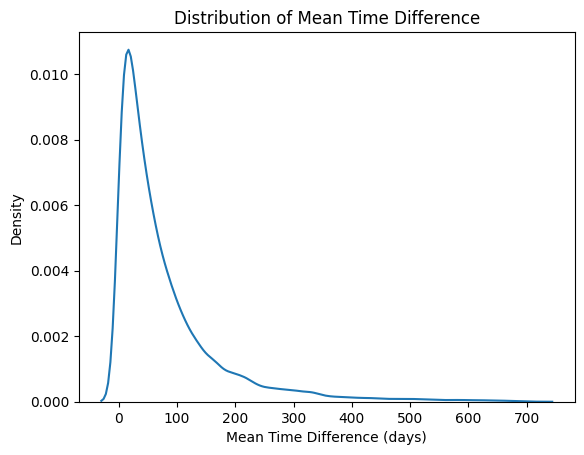

In [39]:
sns.kdeplot(mean_time_diff2['mean_time_diff'])
plt.title('Distribution of Mean Time Difference')
plt.xlabel('Mean Time Difference (days)')
plt.ylabel('Density')
plt.show()


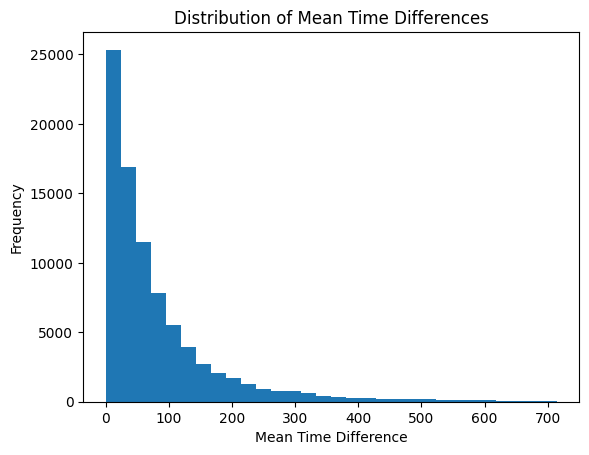

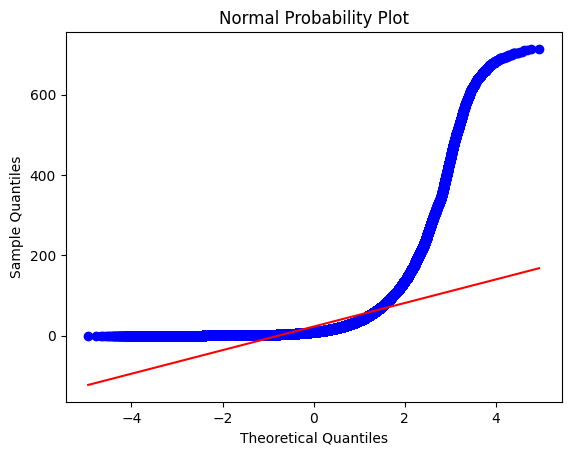

In [19]:
import scipy.stats as stats

# Get the mean time differences
mean_time_diff = df_churned.groupby('client_id')['time_diff'].mean()

# Plot histogram
plt.hist(mean_time_diff, bins=30)
plt.title('Distribution of Mean Time Differences')
plt.xlabel('Mean Time Difference')
plt.ylabel('Frequency')

# Plot Q-Q plot
fig, ax = plt.subplots()
res = stats.probplot(df_churned['mean_time_diff'], plot=ax)
ax.set_title('Normal Probability Plot')
ax.set_xlabel('Theoretical Quantiles')
ax.set_ylabel('Sample Quantiles')

plt.show()

In [43]:
mean_time_diff['mean_time_diff'].skew()

2.5739498343264353

In [52]:
# Get the mean time differences
mean_time_diff = df_churned.groupby('client_id')['time_diff'].mean()
mean_time_diff.skew()

2.5739498343264353

In [53]:
##boxcox transform

from scipy.stats import boxcox

# Compute the Box-Cox transformation
mean_time_diff_bc, lam = boxcox(mean_time_diff+1)

# Print the lambda value
print(f"Lambda value: {lam}")


Lambda value: 0.18886745296186372


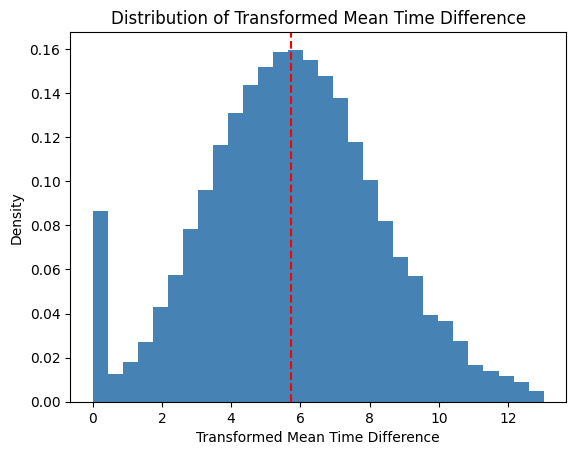

In [62]:
from scipy.stats import boxcox

# Plot histogram of transformed data
plt.hist(mean_time_diff_bc, bins=30, color='steelblue', edgecolor='none', density=True)

# Add labels and title
plt.title('Distribution of Transformed Mean Time Difference')
plt.xlabel('Transformed Mean Time Difference')
plt.ylabel('Density')

# Add vertical line for the mean of the transformed data
plt.axvline(x=mean_time_diff_bc.mean(), color='red', linestyle='--')
plt.show()


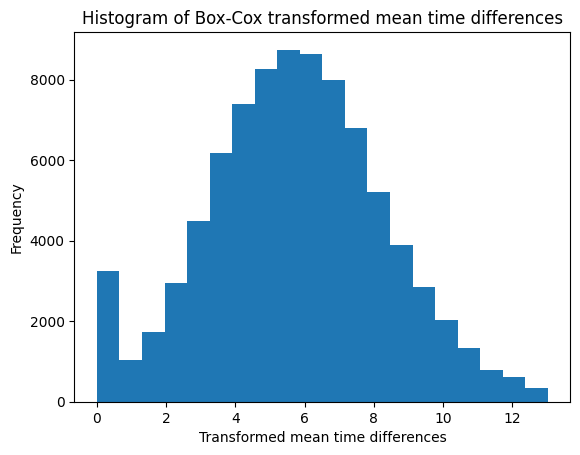

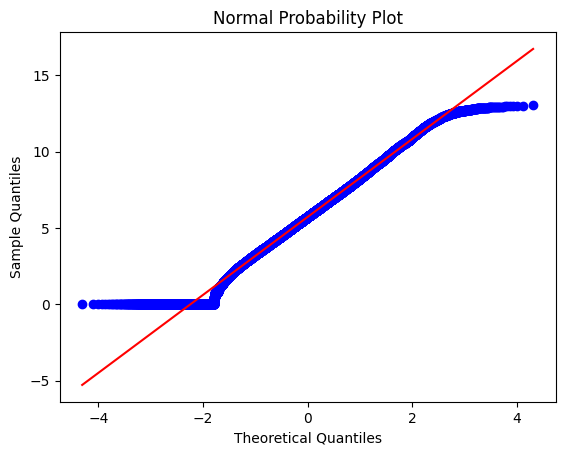

In [63]:
# Plot histogram
plt.hist(mean_time_diff_bc, bins=20)
plt.title('Histogram of Box-Cox transformed mean time differences')
plt.xlabel('Transformed mean time differences')
plt.ylabel('Frequency')
plt.show()

# Plot Q-Q plot
fig, ax = plt.subplots()
stats.probplot(mean_time_diff_bc, plot=ax)
ax.set_title('Normal Probability Plot')
ax.set_xlabel('Theoretical Quantiles')
ax.set_ylabel('Sample Quantiles')
plt.show()

In [66]:
import numpy as np

from scipy.special import inv_boxcox

def compute_churned_clients(df):
    """
    This function computes the average time difference between orders for each client and labels clients as "churned" 
    
    Parameters:
    df (pandas DataFrame): DataFrame containing client_id, date_order, and time_diff columns.
    
    Returns:
    df_churned (pandas DataFrame): DataFrame containing the average time difference between orders for each client, 
    rounded to 2 decimal places, and a column indicating whether the client is "churned" or not.
    """
    # Sort values by client_id and date_order
    df['date_order'] = pd.to_datetime(df['date_order'])
    df.sort_values(by=['client_id', 'date_order'], inplace=True)
    
    # Compute time difference between orders
    df['time_diff'] = df.groupby('client_id')['date_order'].diff().dt.total_seconds()/(24*60*60)
    
    # Compute the average time difference for each client
    mean_time_diff = df.groupby('client_id')['time_diff'].mean().reset_index(name='mean_time_diff')
    mean_time_diff['mean_time_diff'] = round(mean_time_diff['mean_time_diff'], 2)

    # Compute Box-Cox transformation of the mean time differences
    mean_time_diff_bc, lam = boxcox(mean_time_diff['mean_time_diff'] + 1)
    #print(f"Lambda value: {lam}")
    
    # Compute inverse Box-Cox transformation of the mean time differences
    mean_time_diff['mean_time_diff'] = inv_boxcox(mean_time_diff_bc, lam) - 1
    
    # Label clients as "churned" if the maximum time between two orders is 2.5 times greater than the average time difference
    mean_time_diff['churned'] = np.where(mean_time_diff['mean_time_diff'] * 2.5 < df.groupby('client_id')['time_diff'].max().reset_index(name='time_diff')['time_diff'], 1, 0)

    # Join the mean time difference back to the original data
    df_churned = df.merge(mean_time_diff, on='client_id', how='left')

    return df_churned


We create a new column that will flag clients in three categories:
- Good
- Carefull
- Churned

This flag is being created based on a rule based algorithm.

In [69]:
import numpy as np
from scipy.stats import boxcox
from scipy import stats

def compute_churned_clients(df):
    """
    This function computes the average time difference between orders for each client and labels clients as "good", "careful", or "churned".
    
    Parameters:
    df (pandas DataFrame): DataFrame containing client_id, date_order, and time_diff columns.
    
    Returns:
    mean_time_diff (pandas DataFrame): DataFrame containing the average time difference between orders for each client, 
    rounded to 2 decimal places, and a column indicating the client's churn status ("good", "careful", or "churned").
    """
    # Sort values by client_id and date_order
    df['date_order'] = pd.to_datetime(df['date_order'])
    df.sort_values(by=['client_id', 'date_order'], inplace=True)
    
    # Compute time difference between orders
    df['time_diff'] = df.groupby('client_id')['date_order'].diff().dt.total_seconds()/(24*60*60)
    
    # Compute the average time difference for each client
    mean_time_diff = df.groupby('client_id')['time_diff'].mean().reset_index(name='mean_time_diff')

    # Compute the Box-Cox transformation to make the distribution more normal
    mean_time_diff_bc, lam = boxcox(mean_time_diff['mean_time_diff'] + 1)
    
    # Compute mean and standard deviation of transformed data
    mean_bc = np.mean(mean_time_diff_bc)
    std_bc = np.std(mean_time_diff_bc, ddof=1)
    
    # Compute 99% confidence interval for transformed data
    ci_lower_bc, ci_upper_bc = stats.norm.interval(0.99, loc=mean_bc, scale=std_bc)
    
    # Inverse transform the confidence interval back to the original scale
    ci_lower = np.exp(ci_lower_bc) - 1
    ci_upper = np.exp(ci_upper_bc) - 1
    
    # Label clients as "good", "careful", or "churned" based on their mean time difference
    mean_time_diff['churned'] = np.where(mean_time_diff['mean_time_diff'] > ci_upper, 'churned', 
                                          np.where(mean_time_diff['mean_time_diff'] < ci_lower, 'good', 'careful'))
    
    # Round the mean time difference to 2 decimal places
    mean_time_diff['mean_time_diff'] = round(mean_time_diff['mean_time_diff'], 2)

    # Join the mean time difference back to the original data
    df_churned = df.merge(mean_time_diff, on='client_id', how='left')
    
    return df_churned


In [70]:
churned = compute_churned_clients(df_grouped)
churned

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id,order_number,time_diff,mean_time_diff,churned
0,2017-09-26,2017-09-27,2310611,14,160.135200,3,online,10319,1,NaN,1.81,careful
1,2017-09-26,2017-09-26,2927672,14,105.763200,3,online,10319,1,0.0,1.81,careful
2,2017-09-27,2017-10-18,107124,14,372.454333,13,by phone,10319,2,1.0,1.81,careful
3,2017-10-02,2017-10-09,738349,14,1.628400,3,by phone,10319,3,5.0,1.81,careful
4,2017-10-03,2017-10-03,1095180,14,199.078800,3,by phone,10319,4,1.0,1.81,careful
...,...,...,...,...,...,...,...,...,...,...,...,...
1870337,2019-06-04,2019-06-04,2030665,2274410,36.984000,201,at the store,2708,14,0.0,40.00,careful
1870338,2017-11-01,2017-11-01,695452,2274517,69.320160,21,by phone,8488,1,NaN,200.33,careful
1870339,2018-06-27,2018-06-27,1452150,2274517,340.731545,161,by phone,8488,2,238.0,200.33,careful
1870340,2018-08-16,2018-08-20,1452150,2274517,150.254663,71,by phone,8488,3,50.0,200.33,careful


In [64]:
from scipy.special import inv_boxcox


def calculate_churn(df):
    """
    Calculate churn for each client in the given DataFrame.

    Args:
    - df: a Pandas DataFrame containing the order history of clients.
      It should have the following columns:
      - client_id: unique identifier of the client
      - order_date: date of the order
      - time_diff: time difference between the current order and the previous one

    Returns:
    - churned_clients: a list of client IDs that have been flagged as churned
    """

    # Calculate the mean time differences
    mean_time_diff = df.groupby('client_id')['time_diff'].mean()

    # Compute the Box-Cox transformation
    mean_time_diff_bc, lam = boxcox(mean_time_diff+1)

    # Calculate the confidence interval
    mean_bc = np.mean(mean_time_diff_bc)
    std_bc = np.std(mean_time_diff_bc)
    threshold = inv_boxcox(mean_bc + 2.58 * std_bc, lam) - 1

    # Flag the churned clients
    churned_clients = mean_time_diff[mean_time_diff > threshold].index.tolist()

    return churned_clients
